In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('sales-data.csv', header=None)
data.columns=['Month', 'Sales']
data['Month'] = pd.to_datetime(data['Month'], format="%Y-%m")
data = data.set_index('Month')
data.head(12)

,Sales
Month,
1980-01-01,154
1980-02-01,96
1980-03-01,73
1980-04-01,49
1980-05-01,36
1980-06-01,59
1980-07-01,95
1980-08-01,169
1980-09-01,219


In [3]:
from statsmodels.tsa.stattools import kpss

kpss_test = kpss(data['Sales'].dropna())

print('KPSS statistic %f' % kpss_test[0])
print('Critical value @ 0.05: %.2f' %kpss_test[3]['5%'])
print('p-value %f' % kpss_test[1])

KPSS statistic 0.657628
Critical value @ 0.05: 0.46
p-value 0.017397


In [4]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Sales'], lmbda=0), index=data.index)
data_boxcox

Month
1980-01-01    5.036953
1980-02-01    4.564348
1980-03-01    4.290459
1980-04-01    3.891820
1980-05-01    3.583519
                ...   
1986-01-01    6.442540
1986-02-01    5.730100
1986-03-01    5.780744
1986-04-01    5.513429
1986-05-01    5.605802
Length: 77, dtype: float64

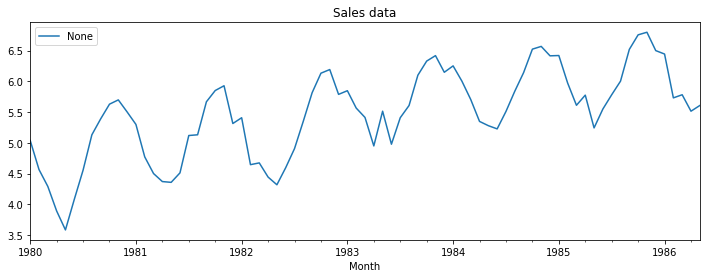

In [5]:
data_boxcox.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title("Sales data")
plt.show(block=False)

In [6]:
data_boxcox_diff = pd.Series(data_boxcox-data_boxcox.shift(), index=data.index)
data_boxcox_diff

Month
1980-01-01         NaN
1980-02-01   -0.472604
1980-03-01   -0.273889
1980-04-01   -0.398639
1980-05-01   -0.308301
                ...   
1986-01-01   -0.055742
1986-02-01   -0.712440
1986-03-01    0.050644
1986-04-01   -0.267315
1986-05-01    0.092373
Length: 77, dtype: float64

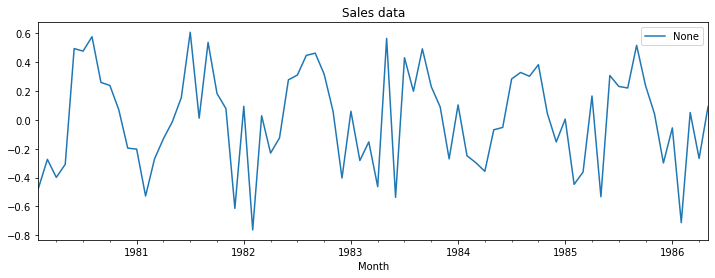

In [7]:
data_boxcox_diff = data_boxcox_diff.dropna()
data_boxcox_diff.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title("Sales data")
plt.show(block=False)


In [8]:
train_len = 60
# cannot use random methods like train_test split since order is important. 
train = data[:train_len] # before 1959
test = data[train_len:] # this is 1959- onwards

In [9]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]

train_data_boxcox_diff = data_boxcox_diff[:train_len]
test_data_boxcox_diff = data_boxcox_diff[train_len:]

In [10]:
from statsmodels.tsa.arima_model import ARIMA
model= ARIMA(train_data_boxcox_diff, order = (4,0,3))
model_fit = model.fit()
print(model_fit.params)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const      0.019611
ar.L1.y    0.255500
ar.L2.y    1.094311
ar.L3.y   -0.640568
ar.L4.y   -0.482682
ma.L1.y   -0.805164
ma.L2.y   -0.768011
ma.L3.y    0.978171
dtype: float64


In [11]:
data_boxcox_diff

Month
1980-02-01   -0.472604
1980-03-01   -0.273889
1980-04-01   -0.398639
1980-05-01   -0.308301
1980-06-01    0.494019
                ...   
1986-01-01   -0.055742
1986-02-01   -0.712440
1986-03-01    0.050644
1986-04-01   -0.267315
1986-05-01    0.092373
Length: 76, dtype: float64

In [12]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] =  model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

In [13]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Sales'] - y_hat_arma['arma_forecast'][train_len-1:])/test['Sales'])*100, 2)

rmse, mape

(207.22, 38.93)

# Arima model

In [14]:
model = ARIMA(data_boxcox, order = (4, 1, 3))  #use boxcox instead of data_boxcox_diff
model_fit = model.fit()
print(model_fit.params)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const        0.019123
ar.L1.D.y    0.159701
ar.L2.D.y    1.146706
ar.L3.D.y   -0.579132
ar.L4.D.y   -0.566278
ma.L1.D.y   -0.661714
ma.L2.D.y   -0.815145
ma.L3.D.y    0.837844
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [15]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arima_forecast_boxcox_diff'] =  model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arima_forecast_boxcox'] = y_hat_arma['arima_forecast_boxcox_diff'].cumsum()
y_hat_arma['arima_forecast_boxcox'] = y_hat_arma['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arima_forecast'] = np.exp(y_hat_arma['arima_forecast_boxcox'])

In [16]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_arma['arima_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Sales'] - y_hat_arma['arima_forecast'][train_len-1:])/test['Sales'])*100, 2)

rmse, mape

(105.1, 22.05)